In [1]:
import stribor as st
import torch
import iisignature 
import numpy as np
import os
from nfsde.experiments.synthetic.data import get_data_loaders
from nfsde.experiments.real.data import get_real_data_loaders
from nfsde.modules.flow_mc import FlowMC
from nfsde.modules.ctfp import CTFPModule
from nfsde.modules.flow_mc_z import FlowMCZ
from nfsde.modules.lsde import LSDE
from nfsde.modules.flow_gan import FlowGAN
from nfsde.modules.sde_gan import SDEGAN
%load_ext autoreload
%autoreload 2

/nfs/homedirs/lui/miniconda3/envs/neuralf2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook computes the maximum mean discrepancy (MMD) between the model samples and real data.

In [47]:
data = get_data_loaders('gompertzian', batch_size=1000)
# data = get_real_data_loaders('energy', batch_size=1000)
num_levels = 5
_, _, dl_train, dl_val, dl_test, mean, std , *_ = data

In [48]:
flow_module_path = [
    'result/flow-mc/hopper/lightning_logs/version_7233365/checkpoints/checkpoint-epoch=0167.ckpt',
    'result/flow-mc/hopper/lightning_logs/version_7233656/checkpoints/checkpoint-epoch=0193.ckpt',
    'result/flow-mc/hopper/lightning_logs/version_7233648/checkpoints/checkpoint-epoch=0236.ckpt',
]
# flow_module_path = [
#     'result/flow-mc/hopper/lightning_logs/version_7193123/checkpoints/checkpoint-epoch=0175.ckpt',
#     'result/flow-mc/hopper/lightning_logs/version_7193133/checkpoints/checkpoint-epoch=0230.ckpt',
#     'result/flow-mc/hopper/lightning_logs/version_7193018/checkpoints/checkpoint-epoch=0171.ckpt',
# ]
flow_module_path = [
    'result/flow-mc/gompertzian/lightning_logs/version_7323765/checkpoints/checkpoint-epoch=0079.ckpt',
    'result/flow-mc/gompertzian/lightning_logs/version_7323769/checkpoints/checkpoint-epoch=0090.ckpt',
    'result/flow-mc/gompertzian/lightning_logs/version_7323764/checkpoints/checkpoint-epoch=0084.ckpt'
]
# data = get_data_loaders('logistic', batch_size=1000)
num_levels = 5
_, _, dl_train, dl_val, dl_test, mean, std , *_ = data

In [49]:
flow_modules = []
for path in flow_module_path:
    module = FlowMC.load_from_checkpoint(path, data=data)
    module.eval()
    flow_modules.append(module)
    

In [50]:
mmd=[]
s2 = None
num_data = 0.
for batch in dl_test:
    x, t, y_true = batch
    t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()
    y_true_detach = y_true_detach

    #data signature
    num_data += x.shape[0]
    streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

    sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
    if s2 is None:
        s2 = sig_true
    else:
        s2 += sig_true

for module in flow_modules:
    print(mmd)
    s1 = None
#     s2 = None
    num_sample = 0.
#     num_data = 0.
    for batch in dl_test:
#         x, t, y_true = batch
#         t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()
#         y_true_detach = y_true_detach#[..., 5:6]

#         #data signature
#         num_data += x.shape[0]
#         streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

#         sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
#         if s2 is None:
#             s2 = sig_true
#         else:
#             s2 += sig_true

        #sample signature
        for i in range(20):
            num_sample += x.shape[0]
            y = module(t) #* std + mean
            y = y.detach().cpu().numpy()
            y= y
            streams = np.concatenate([t_detach, y], axis=-1)
            sig_model = np.asarray([iisignature.sig(s, num_levels) for s in streams]).sum(axis=0)
            if s1 is None:
                s1 = sig_model
            else:
                s1 += sig_model
        

    mmd.append(np.sum((s1 / num_sample - s2 / num_data) ** 2))
    
mmd = np.array(mmd)        
mmd.mean(), mmd.std()

[]
[1.074114454567293]
[1.074114454567293, 0.8273335366835118]


(1.1035853442552768, 0.23850224467528233)

In [18]:
mmd

array([1.12989927, 1.91444714, 0.99114125])

In [72]:
lsde_module_path = [
    'result/latent-sde/energy/lightning_logs/version_7256099/checkpoints/checkpoint-epoch=0030.ckpt',
    'result/latent-sde/energy/lightning_logs/version_7256268/checkpoints/checkpoint-epoch=0065.ckpt',
    'result/latent-sde/energy/lightning_logs/version_7255971/checkpoints/checkpoint-epoch=0064.ckpt'
]
lsde_modules = []
for path in lsde_module_path:
    module = LSDE.load_from_checkpoint(path, data=data)
    module.eval()
    lsde_modules.append(module)

In [73]:
mmd=[]
s2 = None
num_data = 0.
for batch in dl_test:
        x, t, y_true = batch
        t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()

        #data signature
        num_data += x.shape[0]
        streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

        sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
        if s2 is None:
            s2 = sig_true
        else:
            s2 += sig_true
            
for module in lsde_modules:
    print(mmd)
    s1 = None
    num_sample = 0.
    for batch in dl_test:
        x, t, y_true = batch
        t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()

        #sample signature
        for i in range(10):
            print(i)
            num_sample += x.shape[0]
            y = module(t[0].flatten(), x.shape[0]) #* std + mean
            y = y.detach().cpu().numpy()
            streams = np.concatenate([t_detach, y], axis=-1)
            sig_model = np.asarray([iisignature.sig(s, num_levels) for s in streams]).sum(axis=0)
            if s1 is None:
                s1 = sig_model
            else:
                s1 += sig_model
        

    mmd.append(np.sum((s1 / num_sample - s2 / num_data) ** 2))
    
mmd = np.array(mmd)        
mmd.mean(), mmd.std()

[]
0
1
2
3
4
5
6
7
8
9
[595.1262884290823]
0
1
2
3
4
5
6
7
8
9
[595.1262884290823, 595.1068560693665]
0
1
2
3
4
5
6
7
8
9


(595.115757648352, 0.00801643623125829)

In [10]:
mmd

array([0.00852555, 0.00632829, 0.00568358])

In [74]:
ctfp_module_path = [
    'result/ctfp/energy/lightning_logs/version_7257469/checkpoints/checkpoint-epoch=0053.ckpt',
    'result/ctfp/energy/lightning_logs/version_7257470/checkpoints/checkpoint-epoch=0019.ckpt',
    'result/ctfp/energy/lightning_logs/version_7257468/checkpoints/checkpoint-epoch=0064.ckpt'
]
ctfp_modules = []
# data = get_data_loaders('lorenz', batch_size=500)
# data = get_real_data_loaders('baqd', batch_size=500)
num_levels = 5
_, _, dl_train, dl_val, dl_test, mean, std , *_ = data
for path in ctfp_module_path:
    module = CTFPModule.load_from_checkpoint(path, data=data)
    module.eval()
    ctfp_modules.append(module)

In [75]:
mmd=[]
s2 = None
num_data = 0.
for batch in dl_test:
    x, t, y_true = batch
    t = t[:, 1:]
    y_true=y_true[:,1:]
    t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()

    #data signature
    num_data += x.shape[0]
    streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

    sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
    if s2 is None:
        s2 = sig_true
    else:
        s2 += sig_true
        
for module in ctfp_modules:
    print(mmd)
    s1 = None
#     s2 = None
    num_sample = 0.
#     num_data = 0.
    for batch in dl_test:
        x, t, y_true = batch
        t = t[:, 1:]
        y_true=y_true[:,1:]
        t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()

        #data signature
#         num_data += x.shape[0]
#         streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

#         sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
#         if s2 is None:
#             s2 = sig_true
#         else:
#             s2 += sig_true

        #sample signature
        for i in range(15):
            num_sample += x.shape[0]
            y = module(t) #* std + mean
            y = y.detach().cpu().numpy()
#             print(y)
            streams = np.concatenate([t_detach, y], axis=-1)
            sig_model = np.asarray([iisignature.sig(s, num_levels) for s in streams]).sum(axis=0)
            if s1 is None:
                s1 = sig_model
            else:
                s1 += sig_model
#         break
#     break

    mmd.append(np.sum((s1 / num_sample - s2 / num_data) ** 2))
    
mmd = np.array(mmd)        
mmd.mean(), mmd.std()

[]
[1301597306899721.8]
[1301597306899721.8, 371114790222.6173]


(9.95753667105133e+16, 1.3990121194667525e+17)

In [23]:
mmd

array([7.22741793e+24, 1.90808147e+23, 1.32235537e+20])

In [45]:
flow_module_path = [
    'result/flow-gan/ou2/lightning_logs/version_7277047/checkpoints/checkpoint-epoch=1999.ckpt',
    'result/flow-gan/ou2/lightning_logs/version_7277048/checkpoints/checkpoint-epoch=1999.ckpt',
    'result/flow-gan/ou2/lightning_logs/version_7277046/checkpoints/checkpoint-epoch=1999.ckpt'
]
data = get_data_loaders('ou2', batch_size=1000)
num_levels = 5
_, _, dl_train, dl_val, dl_test, mean, std , *_ = data
flow_modules = []
for path in flow_module_path:
    module = FlowGAN.load_from_checkpoint(path, data=data)
#     module.eval()
    flow_modules.append(module)

mmd=[]

for module in flow_modules:
    s1 = None
    s2 = None
    num_sample = 0.
    num_data = 0.
    for batch in dl_test:
        x, t, y_true = batch
        t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()
        t_detach = t_detach/63

        #data signature
        num_data += x.shape[0]
        streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

        sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
        if s2 is None:
            s2 = sig_true
        else:
            s2 += sig_true

        #sample signature
        for i in range(20):
            num_sample += x.shape[0]
            y = module(t, averaged=True) #* std + mean
            y = y.detach().cpu().numpy()
            streams = np.concatenate([t_detach, y], axis=-1)
            sig_model = np.asarray([iisignature.sig(s, num_levels) for s in streams]).sum(axis=0)
            if s1 is None:
                s1 = sig_model
            else:
                s1 += sig_model
        

    mmd.append(np.sum((s1 / num_sample - s2 / num_data) ** 2))
    
mmd = np.array(mmd)        
mmd.mean(), mmd.std()

(15.403930587871558, 20.51994794521418)

In [46]:
mmd

array([44.42108836,  1.22063855,  0.57006485])

In [41]:
flow = flow_modules[0]
sde = sde_modules[0]
y_flow = flow(t, averaged=True)
y_sde = sde(t, averaged=True)
critic1 = flow.discriminator(torch.cat([t, y_flow], dim=-1))
critic2 = flow.discriminator(torch.cat([t, y_sde], dim=-1))
critic3 = flow.discriminator(torch.cat([t, y_true], dim=-1))
critic1/critic3, critic2/critic3, critic3

(tensor(0.4966, grad_fn=<DivBackward0>),
 tensor(-0.4027, grad_fn=<DivBackward0>),
 tensor(18.4644, grad_fn=<MeanBackward0>))

In [40]:
critic1 = sde.discriminator(torch.cat([t, y_flow], dim=-1))
critic2 = sde.discriminator(torch.cat([t, y_sde], dim=-1))
critic3 = sde.discriminator(torch.cat([t, y_true], dim=-1))
critic1/critic3, critic2/critic3, critic3

(tensor(0.8561, grad_fn=<DivBackward0>),
 tensor(0.9346, grad_fn=<DivBackward0>),
 tensor(70.7873, grad_fn=<MeanBackward0>))

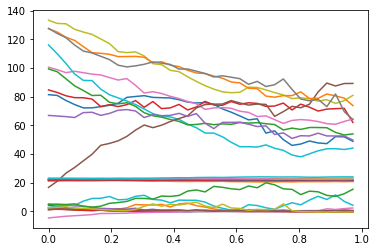

In [69]:
# i=0
# losses = []
# with torch.no_grad():
#     for batch in dl_test:
#         i += 1
#         x, t, y_true = batch
#         break

# module = ctfp_modules[0]
# y = module(t) * module.std + module.mean
import matplotlib.pyplot as plt
# a = plt.subplot(projection='3d')
# y = lsde_modules[0](t[0].flatten(), 10) * std + mean
y = flow_modules[0](t) * std + mean
q = y.detach().cpu().numpy()
for i in range(10):
#     plt.plot(t[i], y_true[i] * std + mean)
    plt.plot(t[i], q[i])
#     plt.plot(q[i,:,0],q[i,:,1],q[i,:,2])

In [64]:
t[:,1]


tensor([[0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0.0278],
        [0

In [59]:
y_true

tensor([[[-0.3551, -0.4773,  0.8197],
         [-0.4582, -0.4773,  0.8197],
         [-0.4582, -0.4773,  0.8197],
         ...,
         [-0.3551,  2.1103,  0.7958],
         [ 0.2636,  3.4041,  0.8197],
         [-0.4582,  2.1103,  0.8360]],

        [[-0.3551, -0.4773, -0.7650],
         [-0.5613, -0.4773, -0.8084],
         [-0.4582, -0.4773, -0.8084],
         ...,
         [ 0.0573,  0.8165, -1.0689],
         [ 0.2636,  0.8165, -1.0038],
         [ 0.2636,  0.8165, -1.0038]],

        [[-0.3551,  3.4041, -0.2288],
         [-0.3551,  2.1103, -0.2288],
         [-0.3551,  3.4041, -0.2288],
         ...,
         [-0.5613,  0.8165, -0.9452],
         [-0.6644, -0.4773, -0.9452],
         [-0.7676,  0.8165, -1.0038]],

        ...,

        [[-0.1489, -0.4773, -1.4836],
         [ 0.1605, -0.4773, -1.4380],
         [ 5.8317, -0.4773, -1.3946],
         ...,
         [ 3.2539, -0.4773, -0.0269],
         [ 2.5321, -0.4773, -0.0704],
         [ 1.9134, -0.4773, -0.0921]],

        [[

In [43]:
sde_module_path = [
    'result/sde-gan/ou2/lightning_logs/version_7295861/checkpoints/checkpoint-epoch=1999.ckpt',
    'result/sde-gan/ou2/lightning_logs/version_7295862/checkpoints/checkpoint-epoch=1999.ckpt',
    'result/sde-gan/ou2/lightning_logs/version_7295860/checkpoints/checkpoint-epoch=1999.ckpt'   
]
data = get_data_loaders('ou2', batch_size=1000)
num_levels = 5
_, _, dl_train, dl_val, dl_test, mean, std , *_ = data
sde_modules = []
for path in sde_module_path:
    module = SDEGAN.load_from_checkpoint(path, data=data)
#     module.eval()
    sde_modules.append(module)

mmd=[]

for module in sde_modules:
    s1 = None
    s2 = None
    num_sample = 0.
    num_data = 0.
    for batch in dl_test:
        x, t, y_true = batch
        t_detach, y_true_detach = t.detach().cpu().numpy(), y_true.detach().cpu()
        t_detach=t_detach/63

        #data signature
        num_data += x.shape[0]
        streams2 = np.concatenate([t_detach, y_true_detach], axis=-1)

        sig_true = np.asarray([iisignature.sig(s, num_levels) for s in streams2]).sum(axis=0)
        if s2 is None:
            s2 = sig_true
        else:
            s2 += sig_true

        #sample signature
        for i in range(20):
            num_sample += x.shape[0]
            y = module(t, averaged=True) #* std + mean
            y = y.detach().cpu().numpy()
            streams = np.concatenate([t_detach, y], axis=-1)
            sig_model = np.asarray([iisignature.sig(s, num_levels) for s in streams]).sum(axis=0)
            if s1 is None:
                s1 = sig_model
            else:
                s1 += sig_model
        

    mmd.append(np.sum((s1 / num_sample - s2 / num_data) ** 2))
    
mmd = np.array(mmd)        
mmd.mean(), mmd.std()

(40.558207917865865, 57.336222713991305)

In [44]:
mmd

array([1.21643871e+02, 2.26095444e-02, 8.14294416e-03])

In [23]:
i=0
losses = []
with torch.no_grad():
    for batch in dl_test:
        i += 1
        x, t, y_true = batch
        losses.append(lsde_modules[0].test_step(batch, i))
        print(i)
np.array(losses).mean()        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


4.446781

In [47]:
g = LatentCouplingFlow(1,1,4,[64]*2, 'TimeFourierBounded', 8)
g.load_state_dict(torch.load(os.getcwd()+'/nfsde/result/model.pt'))

<All keys matched successfully>

In [107]:
mmd = []
esig.is_library_loaded()
for batch in dl_test:
    x, t, y_true = batch
    ws = sample_brownian(t)
    y = g(x, ws, t)
    t, y, y_true = t.detach().cpu().numpy(), y.detach().cpu().numpy(), y_true.detach().cpu()
    streams = np.concatenate([t, y], axis=-1)
    sig_model = np.asarray([esig.tosig.stream2sig(s, num_levels) for s in streams]).mean(axis=0)
    streams2 = np.concatenate([t, y_true], axis=-1)
    sig_true = np.asarray([esig.tosig.stream2sig(s, num_levels) for s in streams2]).mean(axis=0)
    mmd.append(sig_model - sig_true)
mmd = np.mean(mmd, axis=0)
np.sum(mmd**2)
# mmd

9.843329160731395e+46

In [152]:
y = 0
x = torch.zeros(100, 1, 1)
for i in range(1):
    t = torch.linspace(0, 10, 101).view(1,-1,1).repeat_interleave(100, dim=0)
    ws = sample_brownian(t)
    y += g(x, ws, t).mean(0)
    print(g(x, ws, t))
    break
y / 5

tensor([[[ 0.0000],
         [ 0.1344],
         [ 0.4758],
         ...,
         [-0.4300],
         [-0.6819],
         [-0.2360]],

        [[ 0.0000],
         [ 3.2161],
         [ 1.4512],
         ...,
         [ 2.4921],
         [ 3.1058],
         [ 2.7891]],

        [[ 0.0000],
         [ 0.0119],
         [ 0.8310],
         ...,
         [ 3.6492],
         [ 2.1081],
         [ 1.1985]],

        ...,

        [[ 0.0000],
         [ 1.5002],
         [ 3.1224],
         ...,
         [ 1.1565],
         [ 3.4226],
         [ 3.8300]],

        [[ 0.0000],
         [ 1.2166],
         [ 0.2478],
         ...,
         [-1.4129],
         [-1.4455],
         [-1.3873]],

        [[ 0.0000],
         [ 3.6598],
         [ 5.1615],
         ...,
         [-1.3782],
         [-1.3145],
         [-1.2748]]], grad_fn=<AddBackward0>)


tensor([[ 0.0000],
        [ 0.0939],
        [ 0.1430],
        [ 0.1256],
        [ 0.1484],
        [ 0.2102],
        [ 0.2146],
        [ 0.2255],
        [ 0.2378],
        [ 0.1850],
        [ 0.1503],
        [ 0.0913],
        [ 0.1548],
        [ 0.1520],
        [ 0.0928],
        [ 0.1453],
        [ 0.1290],
        [ 0.1549],
        [ 0.0796],
        [ 0.1489],
        [ 0.1587],
        [ 0.2286],
        [ 0.2283],
        [ 0.2526],
        [ 0.2047],
        [ 0.2039],
        [ 0.1529],
        [ 0.2054],
        [ 0.1826],
        [ 0.1607],
        [ 0.1799],
        [ 0.1734],
        [ 0.1125],
        [ 0.1376],
        [ 0.0960],
        [ 0.0886],
        [ 0.0758],
        [ 0.0626],
        [ 0.0659],
        [ 0.0346],
        [ 0.0305],
        [ 0.0321],
        [ 0.0394],
        [ 0.0214],
        [ 0.0007],
        [ 0.0638],
        [ 0.0650],
        [ 0.1073],
        [ 0.0529],
        [ 0.0758],
        [ 0.0583],
        [ 0.0268],
        [ 0.

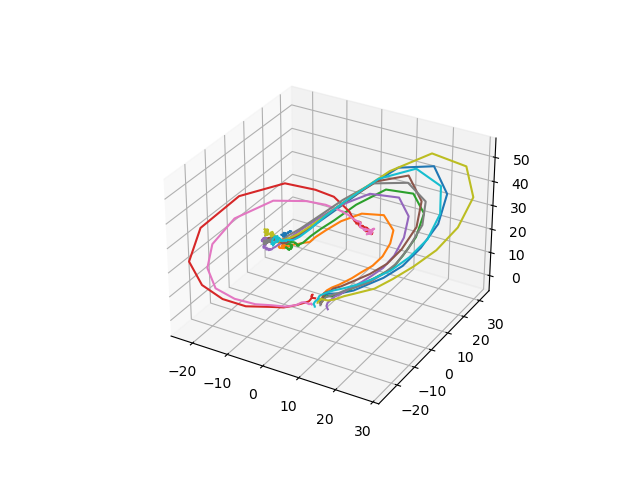

In [16]:
from IPython.display import Image
Image(filename='result/latent-sde/lorenz/lightning_logs/version_7164518/plot.png') 